In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.cuda
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms

import os

In [2]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [3]:
# Setting device to CUDA if gpu is available, else setting device to CPU
# GPU availability can be checked using torch.cuda.is_available() function call
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [28]:
# Setting the path to the images folder
PATH = os.getcwd() + "/thumbnails128x128/"
data_dir = PATH 

In [29]:
transform = transforms.Compose([transforms.Resize(255), transforms.ToTensor()]) # transforming the data

# Loading and transforming the entire dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)                 

# dividing the entire dataset to training and testing datasets
len_train = int(len(dataset)*0.8)
len_test = len(dataset) - len_train
lengths = [len_train, len_test]
train_dataset, val_dataset = random_split(dataset, lengths)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

In [63]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

In [36]:
# Visualizing an image from the dataset
images, _ = next(iter(val_dataloader))

# Creating images with gaussian noise
noisy_images = (images + torch.normal(0,0.2, images.shape)).clip(0,1)

# Creating noisy images with bernouilli noise
a = 0.7*torch.ones(images.shape)
bernouilli_noisy_images = images*torch.bernoulli(a)

# Creating poisson noise images
a = 5*torch.ones(images.shape)
p = torch.poisson(a)
p_norm = p/p.max()
poisson_noisy_images = (images + p_norm).clip(0,1)

# Visualizing noisy images
imshow(noisy_images[1], normalize=False)
imshow(bernouilli_noisy_images[1], normalize=False)
imshow(poisson_noisy_images[1], normalize=False)


In [42]:
# Helper functions to evaluate denoising approaches
EPS = 1e-8

def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

print(f"PSNR [  0-noise ] = {PSNR(images, images)}\n")
print(f"PSNR [ Gaussian ] = {PSNR(images, noisy_images)}\n")
print(f"PSNR [Bernouilli] = {PSNR(images, bernouilli_noisy_images)}\n")
print(f"PSNR [  Poisson ] = {PSNR(images, poisson_noisy_images)}\n")

PSNR [  0-noise ] = tensor([80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80.])

PSNR [ Gaussian ] = tensor([14.7876, 14.9469, 15.0134, 14.7741, 15.0428, 15.0603, 14.4740, 14.9572,
        14.9597, 15.5714, 15.1099, 15.3335, 14.5348, 14.8895, 14.7420, 16.0082])

PSNR [Bernouilli] = tensor([11.3693, 12.4657, 13.0510, 11.6177, 11.6525, 11.0017, 11.0173, 12.9985,
         9.5058, 11.5340, 13.9825, 11.9971, 11.1153, 11.2188, 10.5264, 15.8976])

PSNR [  Poisson ] = tensor([11.8213, 11.7090, 11.5299, 11.6276, 11.7853, 12.0697, 11.6126, 11.5169,
        12.5395, 12.0459, 11.3861, 11.8571, 11.7178, 11.8294, 12.1148, 11.4473])



### Denoising using autoencoders

In [46]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = Sequential(
            Conv2d(3, 32, kernel_size=(3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding=0),
            Conv2d(32, 64, kernel_size=(3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding=0),
            Conv2d(64, 128, kernel_size=(3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding=0)
        )
        self.decoder = Sequential(
            ConvTranspose2d(128, 128, kernel_size=(3,3), stride=2, padding=0),
            ReLU(),
            ConvTranspose2d(128, 64, kernel_size=(3,3), stride=2, padding=0),
            ReLU(),
            ConvTranspose2d(64, 32, kernel_size=(3,3), stride=2, padding=0),
            ReLU(),
            ConvTranspose2d(32, 3, kernel_size=(3,3), stride=1, padding=1),
            Sigmoid()
        )
        
    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

# printing summary of autoencoder
print(autoencoders(), torch.zeros((1, 3, 255, 255)))

autoencoders(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
) tensor([[[[0., 0., 0

In [55]:
def eval_model(model, val_dataloader, noise_type, noise_parameter, pfx='train'):
    model.eval()
    psnr = []
    mse = []
    with torch.no_grad():
        for images, _ in val_dataloader:
            if (noise_type == "normal"):
                noisy_images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                noisy_images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                noisy_images = (images + p_norm).clip(0,1)
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            preds = model(images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(images.cpu().detach(), preds.cpu().detach()))
        print(f"[{pfx}] Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean():10.6f} || Std: {np.array(psnr).std():10.6f}")
        print(f"[{pfx}]      Mean Squared Error   :   Mean: {np.array(mse).mean():10.6f} || Std: {np.array(mse).std():10.6f}")
        return np.array(psnr).mean(), np.array(mse).mean()
    
    
def train_model(model, noise_type, noise_parameter, optimizer, 
                train_dataloader, val_dataloader, loss_module, 
                target_type="clean", num_epochs=30):
    model.train()
    epoch_num = []
    mse_train = []
    mse_val = []
    psnr_train = []
    psnr_val = []
    mse = 0.0
    psnr = 0.0
    for epoch in range(num_epochs):
        for images, _ in train_dataloader:
            targets = torch.clone(images)
            if (noise_type == "normal"):
                images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                images = (images + p_norm).clip(0,1)
            if (target_type == "noisy"):
                if (noise_type == "normal"):
                    targets = (targets + torch.normal(0,noise_parameter,targets.shape)).clip(0,1)
                elif (noise_type == "bernoulli"):
                    a = noise_parameter*torch.ones(targets.shape)
                    targets = targets*torch.bernoulli(a)
                elif (noise_type == "poisson"):
                    a = noise_parameter*torch.ones(targets.shape)
                    p = torch.poisson(a)
                    p_norm = p/p.max()
                    targets = (targets + p_norm).clip(0,1)           
            images = images.to(device)
            targets = targets.to(device)
            preds = model(images)
            loss = loss_module(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch%3 == 0):
            print(f"******** EPOCH {epoch+1}: ********")
            epoch_num.append(epoch+1)
            
            psnr, mse = eval_model(model, train_dataloader, noise_type, noise_parameter, pfx='train')
            psnr_train.append(psnr)
            mse_train.append(mse)
            
            psnr, mse = eval_model(model, val_dataloader, noise_type, noise_parameter, pfx='valid')
            psnr_val.append(psnr)
            mse_val.append(mse)

In [56]:
normal_ae_mse = autoencoders()
normal_optimizer_mse = optim.Adam(normal_ae_mse.parameters(), lr=1e-3)
normal_ae_mse = normal_ae_mse.to(device)

bernoulli_ae = autoencoders()
bernoulli_optimizer = optim.Adam(bernoulli_ae.parameters(), lr=1e-3)
bernoulli_ae = bernoulli_ae.to(device)

poisson_ae = autoencoders()
poisson_optimizer = optim.Adam(poisson_ae.parameters(), lr=1e-3)
poisson_ae = poisson_ae.to(device)

In [57]:
%%time
loss_module = MSELoss()

train_model(normal_ae_mse, "normal", 0.2, normal_optimizer_mse, 
            train_dataloader, val_dataloader, loss_module, num_epochs=10)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axs = axs.flatten()

image_num = np.random.randint(16)

images = images.float().to(device)
imshow(images[image_num].cpu().detach(), normalize=False, ax=axs[0], title='True')
imshow(noisy_images[image_num], normalize=False, ax=axs[1], title='Noisy')

output = normal_ae_mse(images)
imshow(output[image_num].cpu().detach(), normalize=False, ax=axs[2], title='Denoised')

plt.show(fig)

print(f"PSNR = {PSNR(images, output)}")

******** EPOCH 1: ********
[train] Peak Signal to Noise Ratio:   Mean:  18.879442 || Std:   1.273721
[train]      Mean Squared Error   :   Mean:   0.013494 || Std:   0.003863
[valid] Peak Signal to Noise Ratio:   Mean:  18.881332 || Std:   1.258481
[valid]      Mean Squared Error   :   Mean:   0.013476 || Std:   0.003805
******** EPOCH 4: ********
[train] Peak Signal to Noise Ratio:   Mean:  18.568771 || Std:   1.312704
[train]      Mean Squared Error   :   Mean:   0.014518 || Std:   0.004174
[valid] Peak Signal to Noise Ratio:   Mean:  18.547653 || Std:   1.328484
[valid]      Mean Squared Error   :   Mean:   0.014607 || Std:   0.004233
******** EPOCH 7: ********
[train] Peak Signal to Noise Ratio:   Mean:  19.211863 || Std:   1.590615
[train]      Mean Squared Error   :   Mean:   0.012788 || Std:   0.004573
[valid] Peak Signal to Noise Ratio:   Mean:  19.185633 || Std:   1.617124
[valid]      Mean Squared Error   :   Mean:   0.012892 || Std:   0.004653
******** EPOCH 10: ********
[tr

In [ ]:
%%time
loss_module = MSELoss()

train_model(bernoulli_ae, "bernoulli", 0.2, bernoulli_optimizer, 
            train_dataloader, val_dataloader, loss_module, num_epochs=10)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axs = axs.flatten()

image_num = np.random.randint(16)

images = images.float().to(device)
imshow(images[image_num].cpu().detach(), normalize=False, ax=axs[0], title='True')
imshow(noisy_images[image_num], normalize=False, ax=axs[1], title='Noisy')

output = normal_ae_mse(images)
imshow(output[image_num].cpu().detach(), normalize=False, ax=axs[2], title='Denoised')

plt.show(fig)

print(f"PSNR = {PSNR(images, output)}")

******** EPOCH 1: ********
[train] Peak Signal to Noise Ratio:   Mean:  22.644260 || Std:   1.313522
[train]      Mean Squared Error   :   Mean:   0.005728 || Std:   0.002227
[valid] Peak Signal to Noise Ratio:   Mean:  22.670742 || Std:   1.277109
[valid]      Mean Squared Error   :   Mean:   0.005669 || Std:   0.002003
******** EPOCH 4: ********
[train] Peak Signal to Noise Ratio:   Mean:  26.040852 || Std:   1.335025
[train]      Mean Squared Error   :   Mean:   0.002620 || Std:   0.000978
[valid] Peak Signal to Noise Ratio:   Mean:  26.026329 || Std:   1.359743
[valid]      Mean Squared Error   :   Mean:   0.002639 || Std:   0.001119
******** EPOCH 7: ********
[train] Peak Signal to Noise Ratio:   Mean:  27.723598 || Std:   1.390497
[train]      Mean Squared Error   :   Mean:   0.001781 || Std:   0.000629
[valid] Peak Signal to Noise Ratio:   Mean:  27.716537 || Std:   1.361298
[valid]      Mean Squared Error   :   Mean:   0.001780 || Std:   0.000614
******** EPOCH 10: ********
[tr

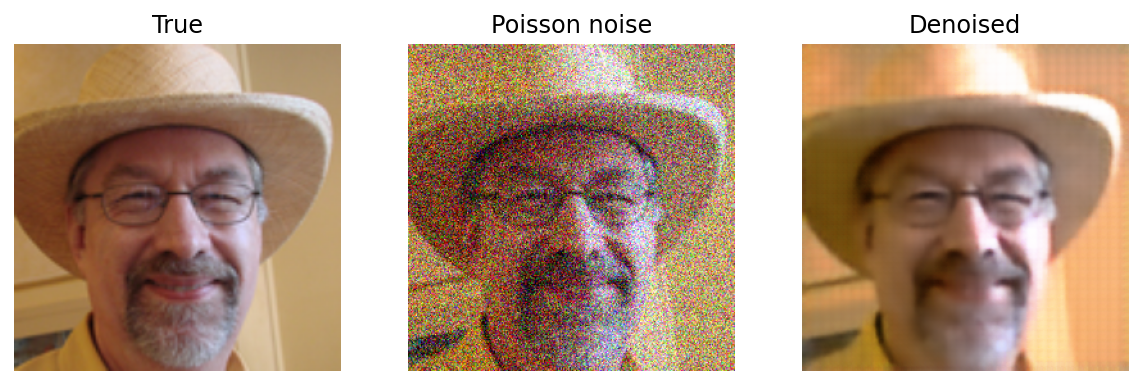

PSNR = tensor([21.7553, 23.6658, 24.1032, 20.1590, 22.3566, 22.7380, 21.4037, 24.2100,
        21.3600, 24.1081, 23.7869, 21.5195, 21.4444, 22.8139, 22.0601, 26.0351],
       device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 21min 5s, sys: 8min 29s, total: 29min 35s
Wall time: 9min 55s


In [76]:
%%time
loss_module = MSELoss()
train_model(poisson_ae, "poisson", 0.2, poisson_optimizer, 
            train_dataloader, val_dataloader, loss_module, num_epochs=10)

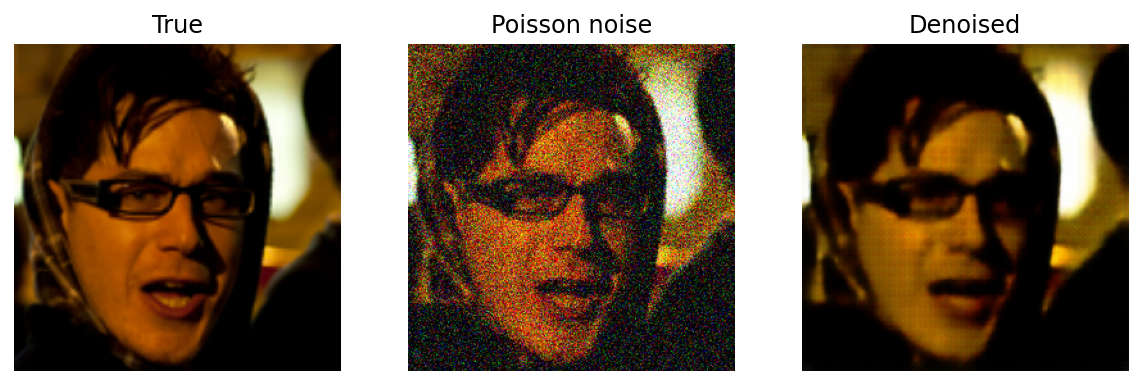

PSNR = tensor([21.7553, 23.6658, 24.1032, 20.1590, 22.3566, 22.7380, 21.4037, 24.2100,
        21.3600, 24.1081, 23.7869, 21.5195, 21.4444, 22.8139, 22.0601, 26.0351],
       device='cuda:0', grad_fn=<MulBackward0>)


In [79]:

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axs = axs.flatten()

image_num = np.random.randint(16)

images = images.float().to(device)
imshow(images[image_num].cpu().detach(), normalize=False, ax=axs[0], title='True')
imshow(noisy_images[image_num], normalize=False, ax=axs[1], title='Poisson noise')

output = normal_ae_mse(images)
imshow(output[image_num].cpu().detach(), normalize=False, ax=axs[2], title='Denoised')

plt.show(fig)

print(f"PSNR = {PSNR(images, output)}")